In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

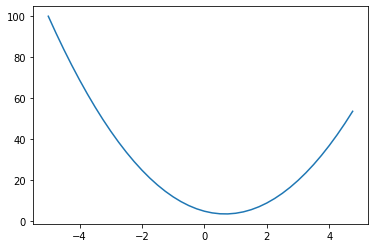

In [4]:
xs= np.arange(-5, 5, 0.25)
ys= f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.000001
x = 2/3
(f(x + h) - f(x)) / h

2.999378523327323e-06

In [6]:
# lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c 
print(d)

4.0


In [7]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c 
c += h
d2 = a*b + c

print('d1', d1)
print("d2", d2)
print("slope", (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [8]:
class Value:
    def __init__(self, data, _childern=(), _op=''):
        self.data = data
        self._prev = set(_childern)
        self._op = _op

    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__ (self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__ (self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c
d

Value(data = 4.0)

In [9]:
d._prev

{Value(data = -6.0), Value(data = 10.0)}

In [10]:
d._op

'+'

In [11]:
from graphviz import Digraph 
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular (record) node for it
        dot.node(name = uid, label = "{data %.4f}" % (n.data, ), shape='record')
        if n._op:
            # if this value is a result of some opertation, create an op npde for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) +n2._op)
    
    return dot

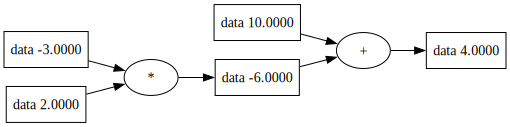

In [12]:
draw_dot(d)